In [2]:
import pandas as pd
import numpy as np
import sqlite3
from plotnine import *

pd.options.display.max_rows = 999

In [3]:
dt = pd.read_csv('../processing/test_train_split.csv')
dt.head()

,track_id,genre,has_musical_ftr,has_lyrics,image_name,has_cover_img,cover_id,is_test
0,TRAAAAV128F421A322,Punk,1,1.0,4b3cc7ae-654e-4408-89e1-4ea70cf86717,1.0,70206.0,0
1,TRAAAEF128F4273421,Pop_Indie,1,1.0,c1f9b340-a37e-4dc8-aaf9-f622c5457f1a,1.0,21597.0,0
2,TRAAAHJ128F931194C,Pop_Indie,1,1.0,dc9b75f9-d5e7-434a-82c4-0d4e9790efd4,1.0,1330.0,0
3,TRAAAHZ128E0799171,Hip_Hop_Rap,1,1.0,62a1cd53-1339-4f04-8113-287b174c3917,1.0,33631.0,2
4,TRAAAJG128F9308A25,Country_Traditional,1,1.0,0cee21c0-9657-469c-9a72-b81bacc88eee,1.0,40306.0,1


In [6]:
# get lyrics data
conn = sqlite3.connect('/storage/thesis/lyrics/mxm_dataset.db')
# conn = sqlite3.connect('../../test_data/lyrics/mxm_dataset.db')
lyr = pd.read_sql_query("SELECT * FROM lyrics", conn)
lyr.head(1)

,track_id,mxm_tid,word,count,is_test
0,TRAAAAV128F421A322,4623710,i,6,0


In [7]:
# filtered down to just the tracks we care about
lyrf = (lyr.drop('is_test', axis=1)
           .merge(dt.loc[:, ['track_id','is_test','genre']], on=['track_id'])
           .drop(['mxm_tid'], axis=1))

In [8]:
df = lyrf.copy()
df.shape

lyrf = lyrf.loc[lyrf['is_test']==0, :]

In [9]:
lyrf.loc[:, 'word_track_cnt'] = lyrf.groupby(['word'])['track_id'].transform(lambda x: x.nunique())
lyrf.loc[:, 'genre_track_cnt'] = lyrf.groupby(['genre'])['track_id'].transform(lambda x: x.nunique())
lyrf.loc[:, 'ttl_track_cnt'] = lyrf['track_id'].nunique()
lyrf.head()

,track_id,word,count,is_test,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt
0,TRAAAAV128F421A322,i,6,0,Punk,39370,1821,49580
1,TRAAAAV128F421A322,the,4,0,Punk,43565,1821,49580
2,TRAAAAV128F421A322,you,2,0,Punk,38202,1821,49580
3,TRAAAAV128F421A322,to,2,0,Punk,41181,1821,49580
4,TRAAAAV128F421A322,and,5,0,Punk,40380,1821,49580


In [10]:
agg = (lyrf.groupby(['word','genre','word_track_cnt','genre_track_cnt','ttl_track_cnt'])
           .agg(track_cnt = ('track_id', 'nunique'))
           .reset_index())
agg.loc[:, 'perc'] = agg['track_cnt'] / agg['word_track_cnt']
agg.loc[:, 'genre_share'] = agg['track_cnt'] / agg['genre_track_cnt']
agg.head()

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share
0,&,Big_Band,698,334,49580,3,0.004298,0.008982
1,&,Blues_Contemporary,698,386,49580,20,0.028653,0.051813
2,&,Country_Traditional,698,2077,49580,34,0.048711,0.016370
3,&,Dance,698,1093,49580,13,0.018625,0.011894
4,&,Electronica,698,877,49580,9,0.012894,0.010262


/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):
/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/stats/smoothers.py:168: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
  "for lowess smoothings.", PlotnineWarning)


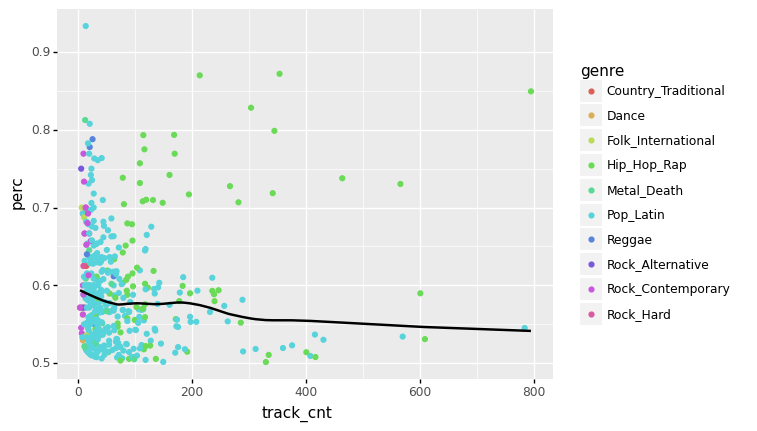

<ggplot: (7285517677)>

In [11]:
(ggplot(agg.loc[agg['perc'] > .5, :], aes(x='track_cnt', y='perc')) +
    geom_point(aes(color='genre')) + 
    geom_smooth())

0.998319917649253

/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_point : Removed 634 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


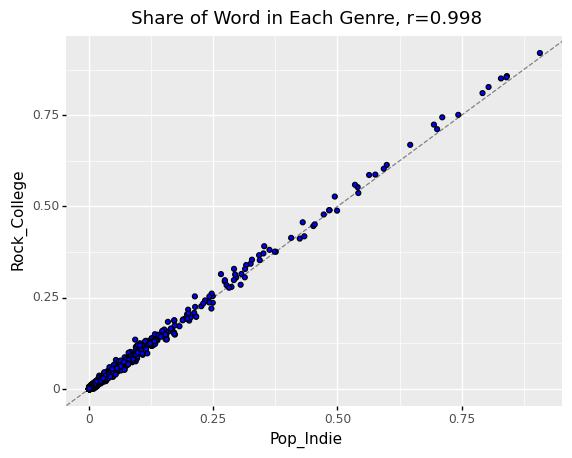

<ggplot: (7091391613)>

In [49]:
pr = agg.loc[agg['genre'].isin(['Rock_College','Pop_Indie']), :].copy()
pr_agg = (pd.pivot_table(pr, index=['word'], columns=['genre'], values=['genre_share'])
            .reset_index(drop=True))
pr_agg.columns = ['Pop_Indie','Rock_College']

(ggplot(pr_agg, 
        aes(x='Pop_Indie', y='Rock_College')) +
    geom_abline(linetype='dashed', color='grey') +
    geom_point(fill='blue') + 
    ggtitle('Share of Word in Each Genre, r={0:.3f}'.format(pr_agg.corr().iloc[0,1])))

In [13]:
agg.loc[agg['perc'] > .5, :].sort_values('genre_share', ascending=False).head(10)

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share
26272,el,Pop_Latin,1438,1129,49580,784,0.545202,0.694420
62403,por,Pop_Latin,1067,1129,49580,570,0.534208,0.504872
3144,amor,Pop_Latin,813,1129,49580,431,0.530135,0.381754
59113,para,Pop_Latin,775,1129,49580,416,0.536774,0.368468
16061,como,Pop_Latin,801,1129,49580,408,0.509363,0.361382
84694,todo,Pop_Latin,719,1129,49580,376,0.522949,0.333038
45961,las,Pop_Latin,693,1129,49580,360,0.519481,0.318866
55435,nigga,Hip_Hop_Rap,936,2572,49580,795,0.849359,0.309098
89325,vida,Pop_Latin,602,1129,49580,312,0.518272,0.276351
27596,esta,Pop_Latin,563,1129,49580,290,0.515098,0.256864


## What about removing hip hop rap and pop latin tracks?

In [17]:
mask = (agg['genre'].isin(['Hip_Hop_Rap','Pop_Latin']) == False)
agg.loc[(agg['perc'] > .3) & mask, :].sort_values('track_cnt').tail(10)

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share
5472,await,Metal_Death,329,3080,49580,120,0.364742,0.038961
83130,thee,Metal_Death,342,3080,49580,121,0.353801,0.039286
13418,chao,Metal_Death,290,3080,49580,128,0.441379,0.041558
16800,consum,Metal_Death,363,3080,49580,136,0.374656,0.044156
6692,beast,Metal_Death,480,3080,49580,145,0.302083,0.047078
68725,rot,Metal_Death,395,3080,49580,149,0.377215,0.048377
23387,divin,Metal_Death,469,3080,49580,151,0.321962,0.049026
27800,etern,Metal_Death,852,3080,49580,286,0.335681,0.092857
72460,shall,Metal_Death,950,3080,49580,296,0.311579,0.096104
31179,flesh,Metal_Death,930,3080,49580,363,0.390323,0.117857


In [18]:
# look at 1 genre at a time
choice_genre = agg['genre'].unique()[20]
print(choice_genre)

(agg.loc[(agg['genre']==choice_genre)&(agg['perc']>.25)&(agg['genre_share']>.1), :]
    .sort_values(['perc','track_cnt'], ascending=[False, False]))
(agg.loc[(agg['genre']==choice_genre)&(agg['perc']>0)&(agg['genre_share']>.1), :]
    .sort_values(['perc','track_cnt'], ascending=[False, False])).head(10)

Rock_Alternative


,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share
46503,leav,Rock_Alternative,6304,2374,49580,337,0.053458,0.141955
56069,noth,Rock_Alternative,6226,2374,49580,328,0.052682,0.138163
5572,away,Rock_Alternative,10176,2374,49580,528,0.051887,0.222409
29038,fall,Rock_Alternative,6580,2374,49580,341,0.051824,0.143639
61446,place,Rock_Alternative,5386,2374,49580,279,0.051801,0.117523
35473,gone,Rock_Alternative,5081,2374,49580,260,0.051171,0.109520
27967,ever,Rock_Alternative,5705,2374,49580,289,0.050657,0.121735
48639,love,Rock_Alternative,16028,2374,49580,811,0.050599,0.341618
38609,here,Rock_Alternative,10547,2374,49580,529,0.050156,0.222831
69605,said,Rock_Alternative,6487,2374,49580,325,0.050100,0.136900


/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


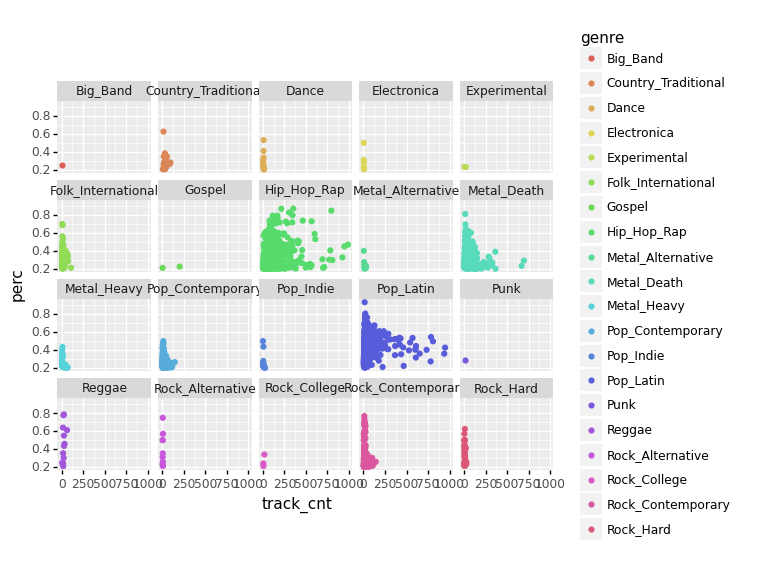

<ggplot: (7223460541)>

In [19]:
(ggplot(agg.loc[(agg['perc'] > .2), :], aes(x='track_cnt', y='perc')) +
    geom_point(aes(color='genre')) +
    facet_wrap('~ genre')) 

/Users/andrewsang/opt/anaconda3/lib/python3.7/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


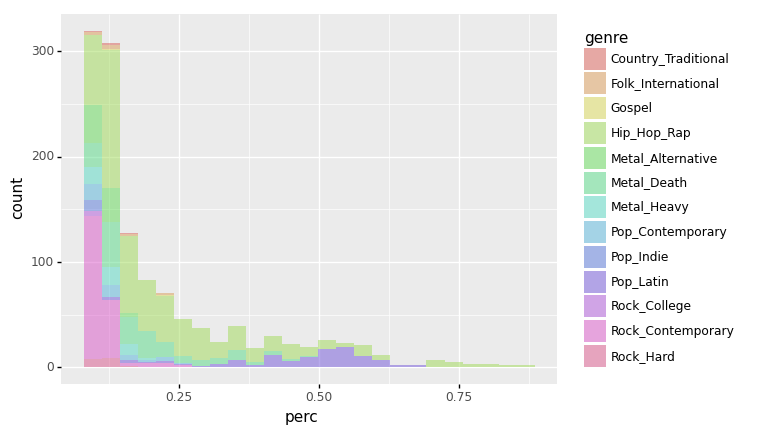

<ggplot: (7058257477)>

In [20]:
ggplot(agg.loc[(agg['track_cnt'] > 100) & (agg['perc'] > .1),:], aes(x='perc')) + geom_histogram(aes(fill='genre'), bins=25, alpha=0.5)

## Are there lyrics that are different words but really similar?

In [21]:
# word2vec solution?
# https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/

In [22]:
# import gensim.downloader as api

ModuleNotFoundError: No module named 'gensim'

In [ ]:
# info = api.info()
# model = api.load("glove-twitter-25")  # download the model and return as object ready for use
# model.most_similar("cat")

In [ ]:
# word = 'cowboy'
# candidate_words = ['jukebox','tennessee','whiskey','monkey','asian','yellow','news','china','america','gaucho','man']
# model.distances(word,candidate_words)

## Maybe instead, we should implement some solution that is similar to tf-idf
* but, use the genre as the documents and the words as the words, so NOT at the track level
* we won't use the actual scores but more as a method for feature / word selection

In [23]:
# term frequency is similar to genre_share
# idf is similar to perc
agg.loc[:,'pseudo_tf'] = agg['genre_share']
agg.loc[:,'pseudo_idf'] = np.log(agg['ttl_track_cnt'] / agg['word_track_cnt'])
agg.loc[:,'pseudo_tfidf'] = agg['pseudo_tf'] * agg['pseudo_idf']
agg.head()

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share,pseudo_tf,pseudo_idf,pseudo_tfidf
0,&,Big_Band,698,334,49580,3,0.004298,0.008982,0.008982,4.263124,0.038292
1,&,Blues_Contemporary,698,386,49580,20,0.028653,0.051813,0.051813,4.263124,0.220887
2,&,Country_Traditional,698,2077,49580,34,0.048711,0.016370,0.016370,4.263124,0.069786
3,&,Dance,698,1093,49580,13,0.018625,0.011894,0.011894,4.263124,0.050705
4,&,Electronica,698,877,49580,9,0.012894,0.010262,0.010262,4.263124,0.043749


In [24]:
agg.sort_values('pseudo_tfidf', ascending=False).head(10)

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share,pseudo_tf,pseudo_idf,pseudo_tfidf
64658,que,Pop_Latin,2220,1129,49580,948,0.427027,0.839681,0.839681,3.106080,2.608117
26272,el,Pop_Latin,1438,1129,49580,784,0.545202,0.694420,0.694420,3.540334,2.458478
20164,de,Pop_Latin,2611,1129,49580,938,0.359249,0.830824,0.830824,2.943854,2.445824
94535,y,Pop_Latin,1623,1129,49580,807,0.497227,0.714792,0.714792,3.419311,2.444096
26643,en,Pop_Latin,1822,1129,49580,733,0.402305,0.649247,0.649247,3.303653,2.144887
45422,la,Pop_Latin,2862,1129,49580,780,0.272537,0.690877,0.690877,2.852067,1.970427
51531,mi,Pop_Latin,1370,1129,49580,610,0.445255,0.540301,0.540301,3.588777,1.939020
62403,por,Pop_Latin,1067,1129,49580,570,0.534208,0.504872,0.504872,3.838737,1.938069
70884,se,Pop_Latin,1813,1129,49580,653,0.360177,0.578388,0.578388,3.308605,1.913657
82137,te,Pop_Latin,1468,1129,49580,605,0.412125,0.535872,0.535872,3.519687,1.886103


In [25]:
agg.sort_values('word_track_cnt', ascending=False).head(10)

,word,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt,track_cnt,perc,genre_share,pseudo_tf,pseudo_idf,pseudo_tfidf
83097,the,Country_Traditional,43565,2077,49580,2002,0.045954,0.963890,0.963890,0.129333,0.124663
83108,the,Metal_Heavy,43565,2823,49580,2601,0.059704,0.921360,0.921360,0.129333,0.119163
83095,the,Big_Band,43565,334,49580,242,0.005555,0.724551,0.724551,0.129333,0.093709
83096,the,Blues_Contemporary,43565,386,49580,344,0.007896,0.891192,0.891192,0.129333,0.115261
83098,the,Dance,43565,1093,49580,918,0.021072,0.839890,0.839890,0.129333,0.108626
83099,the,Electronica,43565,877,49580,690,0.015838,0.786773,0.786773,0.129333,0.101756
83100,the,Experimental,43565,1515,49580,1368,0.031401,0.902970,0.902970,0.129333,0.116784
83101,the,Folk_International,43565,822,49580,339,0.007781,0.412409,0.412409,0.129333,0.053338
83102,the,Gospel,43565,926,49580,864,0.019832,0.933045,0.933045,0.129333,0.120674
83103,the,Grunge_Emo,43565,1561,49580,1471,0.033766,0.942345,0.942345,0.129333,0.121877


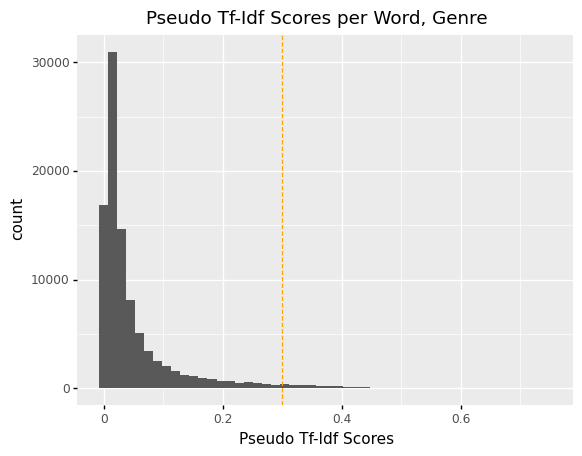

<ggplot: (7077527181)>

In [34]:
(ggplot(agg.loc[agg['pseudo_tfidf']<=.75,:], aes(x='pseudo_tfidf')) + 
     geom_histogram(bins=50) + 
     geom_vline(color='orange', linetype='dashed', xintercept=0.3) + 
     xlab('Pseudo Tf-Idf Scores') +
     ggtitle('Pseudo Tf-Idf Scores per Word, Genre'))

In [ ]:
agg.loc[agg['pseudo_tfidf'].between(.3, 1), :]['word'].nunique()

In [ ]:
(ggplot(agg.loc[agg['pseudo_tfidf'].between(.3, 1),:], aes(x='pseudo_tfidf', fill='genre')) + 
     geom_histogram(bins=25, alpha=0.5, position = "identity"))

In [ ]:
(ggplot(agg.loc[agg['pseudo_tfidf'].between(.3, 1),:], aes(x='pseudo_tfidf', fill='genre')) + 
     #geom_density(bins=25, alpha=0.5, position = "identity"))
     geom_density())

In [ ]:
agg.loc[agg['pseudo_tfidf'] > .3,:].sort_values('pseudo_tfidf', ascending=False).head(10)

In [ ]:
fnl_word_df = (pd.DataFrame(agg.loc[agg['pseudo_tfidf'] > .3, 'word']
                               .drop_duplicates()
                               .reset_index(drop=True)))

In [28]:
lyrf.head()

,track_id,word,count,is_test,genre,word_track_cnt,genre_track_cnt,ttl_track_cnt
0,TRAAAAV128F421A322,i,6,0,Punk,39370,1821,49580
1,TRAAAAV128F421A322,the,4,0,Punk,43565,1821,49580
2,TRAAAAV128F421A322,you,2,0,Punk,38202,1821,49580
3,TRAAAAV128F421A322,to,2,0,Punk,41181,1821,49580
4,TRAAAAV128F421A322,and,5,0,Punk,40380,1821,49580


In [29]:
df['track_id'].nunique()

70596

In [31]:
piv = (pd.pivot_table(df.merge(fnl_word_df, on=['word']), 
                      index='track_id', 
                      columns='word', 
                      values='count', 
                      aggfunc='sum', 
                      fill_value=0)
         .reset_index())

In [32]:
piv.to_csv('/storage/thesis/lyrics/lyrics_piv_trunc.csv')